# Model Implementation

## Initialize Packages

In [13]:
import sys
import pandas as pd
import numpy as np
import os
import rich
import xgboost as xgb
import json
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_tweedie_deviance, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [14]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

## Load Data and Assign Predictors

In [15]:
model_data = pd.read_csv('../backend/model_data.csv')
final_model_data = pd.read_csv('../backend/train_df_final.csv')
final_model_val_data = pd.read_csv('../backend/val_df_final.csv')

In [16]:
final_model_data['claim_cst_per_exposure'] = final_model_data['claimcst0'] / final_model_data['exposure']
final_model_data.head(5)

,id,driving_history_score,credit_score,low_education_ind,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body_grouped,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,1,73.0,646.516469,0.0,0.0,1.0,1.0,2.0,0.0,0.0,161,2.0,2,7.0,5.80,2023.198184,1,1,0.362191,5585.998969
1,2,88.0,635.400369,0.0,1.0,2.0,0.0,1.0,0.0,4.0,100,0.0,4,6.0,5.67,3600.172234,1,1,0.632068,5695.859540
2,3,55.0,646.463131,0.0,0.0,2.0,2.0,1.0,0.0,3.0,74,3.0,2,5.0,5.90,2021.144067,1,1,0.367460,5500.307127
3,4,98.0,645.598794,0.0,0.0,3.0,1.0,1.0,1.0,0.0,121,0.0,3,6.0,4.79,4006.845492,1,1,0.802184,4994.920513
4,5,66.0,657.348612,0.0,1.0,2.0,2.0,2.0,1.0,1.0,75,3.0,3,5.0,6.68,2542.953931,1,1,0.485009,5243.106060


In [17]:
final_model_val_data['claim_cst_per_exposure'] = final_model_val_data['claimcst0'] / final_model_val_data['exposure']
final_model_val_data.head()

,id,driving_history_score,credit_score,low_education_ind,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body_grouped,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,10,74.0,648.136355,0.0,0.0,1.0,1.0,1.0,0.0,1.0,267,0.0,4,8.0,6.49,3906.881054,1,1,0.746884,5230.906470
1,14,59.0,654.686205,0.0,1.0,2.0,3.0,1.0,1.0,1.0,129,1.0,3,5.0,6.56,4260.552605,1,1,0.848036,5024.022799
2,15,62.0,642.842943,0.0,0.0,2.0,2.0,2.0,1.0,3.0,122,3.0,2,5.0,6.09,2056.330796,1,1,0.356544,5767.397041
3,19,83.0,655.733899,0.0,1.0,2.0,1.0,1.0,1.0,1.0,115,3.0,4,5.0,7.13,4756.658716,1,1,0.896206,5307.551484
4,25,63.0,642.523923,0.0,1.0,1.0,0.0,1.0,1.0,3.0,183,3.0,3,7.0,6.37,2347.028119,1,1,0.401096,5851.538632


In [18]:
# Define the list of predictors
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body_grouped', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst # Split the data into training and validation sets
# pred_lst = ['engine_type', 'gender', 'credit_score', 'veh_age', 'agecat', 'area']

train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(11204, 25)
(3796, 25)

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,suv,2,f,b,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,stnwg,4,f,a,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,sedan,2,f,c,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,stnwg,3,m,b,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,sedan,3,m,c,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [19]:
target = 'claim_cst_per_exposure' 

# Use the full list of predictors you defined earlier for consistency
final_preds = [
    'driving_history_score', 'credit_score', 'marital_status',
    'time_driven', 'area', 'agecat_grouped', 'gender', 'veh_color',
    'max_power', 'engine_type', 'veh_age', 'veh_body_grouped', 'veh_value'
]

# Define X and y using the fully processed data file
X = final_model_data[final_preds].copy()
y = final_model_data[target]
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)

print(f"Target variable set to: {target}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Target variable set to: claim_cst_per_exposure
X shape: (11204, 13)
y shape: (11204,)


# XGBoost

In [20]:
# --- Define Final Predictor List ---
pred_lst = [
    'low_education_ind',
    'driving_history_score',
    'credit_score',
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped', 
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body_grouped', 
    'veh_value'
]

# Define X and Y using the final list
X_train = final_model_data[pred_lst].copy()
X_val = final_model_val_data[pred_lst].copy()
y_train = final_model_data[target]
y_val = final_model_val_data[target]

exposure_train = final_model_data['exposure'].astype(float).clip(lower=1e-12)
exposure_val = final_model_val_data['exposure'].astype(float).clip(lower=1e-12)

# Calculate the log offset (base margin)
log_exposure_train = np.log(exposure_train)
log_exposure_val = np.log(exposure_val)

# Define the Tweedie Power (P=1.5 is common for claims cost)
TWEEDIE_POWER = 1.5

# Redefine Num and Cat columns for the new list 
num_cols = ['driving_history_score', 'credit_score', 'max_power', 'veh_value']
cat_cols = [col for col in X_train.columns if col not in num_cols]

In [21]:
# 1. Create DMatrix (using the newly processed cleaned data)
dtrain = xgb.DMatrix(X_train, label=y_train, base_margin=log_exposure_train)
dval = xgb.DMatrix(X_val, label=y_val, base_margin=log_exposure_val)

# 2. Define Parameters for XGBoost
params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': TWEEDIE_POWER,
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 5,
    'seed': 42
}

# 3. Perform Cross-Validation to Find Optimal n_estimators
cv_results = xgb.cv(
    params=params, # Use the defined Tweedie parameters
    dtrain=dtrain,
    num_boost_round=5000, # Max rounds
    nfold=5,  # 5-fold cross-validation
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
)


# Extract the best number of rounds and performance
best_n_estimators = cv_results.shape[0]
best_rmse = cv_results['test-rmse-mean'].min()
best_num_boost_round = len(cv_results)

print(f"Optimal n_estimators: {best_n_estimators}")
print(f"CV Test RMSE: {best_rmse:.4f}")

# 4. Train the Final Model on the entire training set
xgb_model_base = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators
)
print("Final model training with cleaned data complete.")

[0]	train-rmse:3653.17448+72.48635	test-rmse:3642.58359+287.00229
[50]	train-rmse:3637.17922+72.36950	test-rmse:3628.91159+286.93311
[100]	train-rmse:3440.45772+67.07132	test-rmse:3547.83751+283.11591
[150]	train-rmse:3277.81529+65.63011	test-rmse:3546.84519+281.12080
[168]	train-rmse:3234.41828+64.99528	test-rmse:3547.85333+282.31963
Optimal n_estimators: 120
CV Test RMSE: 3544.4569
Final model training with cleaned data complete.


In [30]:
TWEEDIE_POWER = 1.5 
CLIP_VALUE = 1e-6 # Small positive value to enforce strict positivity

# Custom scoring function required for Tweedie in scikit-learn's search
def clipped_tweedie_deviance(y_true, y_pred, power):
    """
    Clips y_true and y_pred to be strictly positive to satisfy the 
    mathematical requirements of the Tweedie deviance calculation (Fixes all ValueErrors).
    """
    # 1. Clip y_true (Actuals): Handles policies with $0 claim cost
    y_true_clipped = np.clip(y_true, a_min=CLIP_VALUE, a_max=None)
    
    # 2. Clip y_pred (Predictions): Fixes the error when cross-validation models 
    # generate non-positive intermediate predictions.
    y_pred_clipped = np.clip(y_pred, a_min=CLIP_VALUE, a_max=None)
    
    return mean_tweedie_deviance(y_true_clipped, y_pred_clipped, power=power)

tweedie_scorer = make_scorer(
    clipped_tweedie_deviance, 
    power=TWEEDIE_POWER, 
    greater_is_better=False # Lower deviance (loss) is better
)
# --- End Custom Scorer Definition --
# Define objects (assuming X_train_processed and y_train are available)
xgb_model_rs = xgb.XGBRegressor(
    objective='reg:tweedie', tweedie_variance_power=TWEEDIE_POWER, random_state=42, n_jobs=-1, eval_metric='rmse' 
)
param_dist = {
    'n_estimators': randint(100, 1000), 'max_depth': randint(3, 10),                    
    'learning_rate': uniform(0.01, 0.2), 'subsample': uniform(0.6, 0.4),                 
    'colsample_bytree': uniform(0.6, 0.4), 'gamma': uniform(0, 0.5),                       
    'reg_alpha': uniform(0, 0.5),                   
}
random_search = RandomizedSearchCV(
    estimator=xgb_model_rs, 
    param_distributions=param_dist, 
    n_iter=50,
    scoring=tweedie_scorer, # ***FIX: Using the callable object instead of the invalid string***
    cv=5, 
    random_state=42, 
    verbose=1, 
    n_jobs=-1
)

print("\nStarting NEW Randomized Hyperparameter Search for 'claimscst0' (Using Tweedie)...")

# CRITICAL: Execute the search
random_search.fit(X_train, y_train, base_margin=log_exposure_train) 


#Extract results
best_params = random_search.best_params_
best_rmse_tuned_claimcost = -random_search.best_score_ 
best_n_estimators = best_params.pop('n_estimators') # Extract n_estimators separately

print("\n--- Hyperparameter Tuning Results for claimscst0 ---")
print(f"Tuned CV RMSE (claimscst0): {best_rmse_tuned_claimcost:.4f}")
print(f"Best n_estimators: {best_n_estimators}")
print("\nBest Other Parameters Found:")
for k, v in best_params.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


Starting NEW Randomized Hyperparameter Search for 'claimscst0' (Using Tweedie)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Hyperparameter Tuning Results for claimscst0 ---
Tuned CV RMSE (claimscst0): 3233048.7939
Best n_estimators: 576

Best Other Parameters Found:
  colsample_bytree: 0.8963
  gamma: 0.3485
  learning_rate: 0.1505
  max_depth: 9
  reg_alpha: 0.1483
  subsample: 0.7679


In [31]:
#Define final model parameters (using the best parameters found)
final_params = {
    'objective': 'reg:tweedie', 'tweedie_variance_power': TWEEDIE_POWER, 'eval_metric': 'rmse', 'seed': 42,
    'eta': best_params['learning_rate'], 'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'], 'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'], 'reg_alpha': best_params['reg_alpha']
}

print(f"\nTraining FINAL model with {best_n_estimators} estimators...")
#Defining the model with the correct variable name
xgb_model_final_tuned = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators # Use the tuned n_estimators
)
model = xgb_model_final_tuned


Training FINAL model with 576 estimators...


<Figure size 1000x800 with 0 Axes>

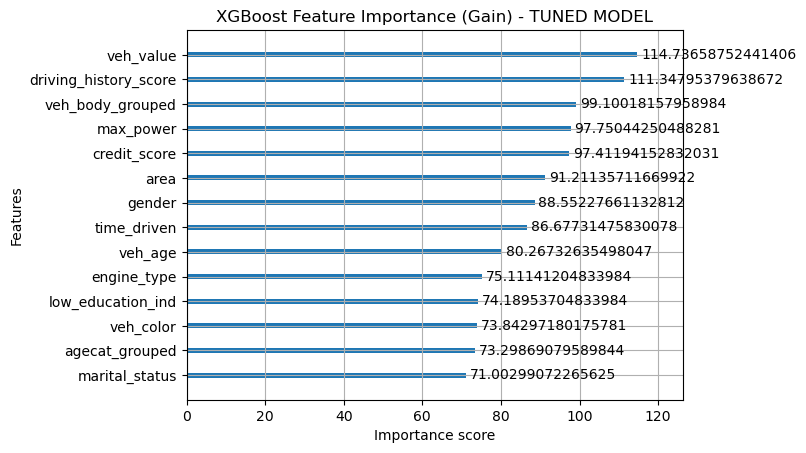


## Top 15 Features by Importance (Gain) - TUNED MODEL:
              Feature  Importance (Gain)
            veh_value         114.736588
driving_history_score         111.347954
     veh_body_grouped          99.100182
            max_power          97.750443
         credit_score          97.411942
                 area          91.211357
               gender          88.552277
          time_driven          86.677315
              veh_age          80.267326
          engine_type          75.111412
    low_education_ind          74.189537
            veh_color          73.842972
       agecat_grouped          73.298691
       marital_status          71.002991


In [33]:
# 1. Get feature importance scores using the FINAL TUNED MODEL
importance = model.get_score(importance_type='gain')

# 2. Convert to DataFrame and sort for plotting
importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Importance (Gain)']
).sort_values(by='Importance (Gain)', ascending=False)

# 3. Plot the top 15 features
plt.figure(figsize=(10, 8))
try:
    xgb.plot_importance(
        model, 
        importance_type='gain', 
        max_num_features=15, 
        title='XGBoost Feature Importance (Gain) - TUNED MODEL'
    )
    plt.show()
except Exception:
    print("Could not plot feature importance directly. Displaying table instead.")
    
# Display the top 15 most important features
print("\n## Top 15 Features by Importance (Gain) - TUNED MODEL:")
print(importance_df.head(15).to_string(index=False))

In [34]:
# 1. Generate predictions using the final tuned model
predictions_train = model.predict(dtrain)

# --- 2. Calculate Base Metrics ---
# Calculate the RMSE (Root Mean Square Error)
rmse_train = np.sqrt(np.mean((y_train - predictions_train)**2))


# --- 3. Clipping for Tweedie Requirement (y > 0 and y_pred > 0) ---
CLIP_VALUE = 1e-6 
y_clipped = np.clip(y_train, a_min=CLIP_VALUE, a_max=None)
predictions_train_clipped = np.clip(predictions_train, a_min=CLIP_VALUE, a_max=None)

# --- 4. Calculate Advanced Metrics ---
# Gini Coefficient
me = ModelEvaluation(y_clipped, predictions_train_clipped) 
gini = me.gini()

# MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_clipped, predictions_train_clipped)

# Tweedie Deviance (using power=1.0 for Poisson/Claim Count alignment)
tweedie_dev_train = mean_tweedie_deviance(
    y_true=y_clipped, 
    y_pred=predictions_train_clipped, 
    power=1.0
)

# --- 5. Print Results ---
print(f"\n--- Final Model Evaluation on TRAINING Set (Claim Cost) ---")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Training Gini Coefficient: {gini:.4f} (Ranking Power)")
print(f"Training MAE: {mae_train:.2f} (Average Dollar Error)")


--- Final Model Evaluation on TRAINING Set (Claim Cost) ---
Training RMSE: 107.8558
Training Gini Coefficient: 0.9555 (Ranking Power)
Training MAE: 17.15 (Average Dollar Error)


In [35]:
# 1. Generate predictions using the final tuned model
predictions_val = model.predict(dval)

# --- 2. Calculate Base Metrics ---
r_squared_val = r2_score(y_val, predictions_val)
rmse_val = np.sqrt(np.mean((y_val - predictions_val)**2))

# --- 3. Clipping for Metrics (Required for Tweedie/Gini) ---
CLIP_VALUE = 1e-6
y_val_clipped = np.clip(y_val, a_min=CLIP_VALUE, a_max=None)
predictions_val_clipped = np.clip(predictions_val, a_min=CLIP_VALUE, a_max=None)

# --- 4. Calculate Advanced Metrics ---
# Gini Coefficient
me_val = ModelEvaluation(y_val_clipped, predictions_val_clipped) 
gini_val = me_val.gini()

# MAE (Mean Absolute Error)
mae_val = mean_absolute_error(y_val_clipped, predictions_val_clipped)

# Tweedie Deviance (using power=1.0 for Claim Cost)
tweedie_dev_val = mean_tweedie_deviance(
    y_true=y_val_clipped, 
    y_pred=predictions_val_clipped, 
    power=TWEEDIE_POWER
)

# --- 5. Print Results & Check for Overfitting ---
print(f"\n--- Final Model Evaluation on VALIDATION Set (Claim Cost) ---")
print(f"Validation Gini Coefficient: {gini_val:.4f} (Ranking Power)")
print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.2f}")


--- Final Model Evaluation on VALIDATION Set (Claim Cost) ---
Validation Gini Coefficient: 0.2446 (Ranking Power)
Validation RMSE: 3590.9884
Validation MAE: 778.59


## Frequency-Severity Modeling

In [67]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support

final_preds = [
    'driving_history_score', # was supposed to drop, but this feels important for insurance
    'credit_score',
    # 'low_education_ind', # dropped based on results of varclushi
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped',
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body_grouped',
    'veh_value' # were supposed to drop this but it doesn't make much sense to do
]

# Define features and target
y = final_model_data['claimcst0'].astype(float)
X = final_model_data[final_preds].copy()
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)

In [68]:
# XGBoost DMatrix with offset
dtrain = xgb.DMatrix(
    X,
    label=y,
    base_margin=np.log(exposure)   # log exposure offset
)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',
    'eval_metric': 'tweedie-nloglik@1.5',
    'tweedie_variance_power': 1.5,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.0,
    'nthread': -1,
    'seed': 42,
    'tree_method': 'hist',
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=5000,
    nfold=5,  # 5-fold cross-validation
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

[0]	train-tweedie-nloglik@1.5:1121.95791+28.99751	test-tweedie-nloglik@1.5:1121.95260+115.99175


[50]	train-tweedie-nloglik@1.5:683.18844+17.58612	test-tweedie-nloglik@1.5:683.54164+70.56789
[100]	train-tweedie-nloglik@1.5:419.04124+10.68372	test-tweedie-nloglik@1.5:421.42694+42.87675
[150]	train-tweedie-nloglik@1.5:261.87141+6.49475	test-tweedie-nloglik@1.5:268.03010+27.42385
[200]	train-tweedie-nloglik@1.5:170.05460+3.91931	test-tweedie-nloglik@1.5:179.27524+18.22876
[250]	train-tweedie-nloglik@1.5:118.16671+2.53185	test-tweedie-nloglik@1.5:129.80622+12.75219
[300]	train-tweedie-nloglik@1.5:90.49741+1.70830	test-tweedie-nloglik@1.5:103.61753+9.65292
[350]	train-tweedie-nloglik@1.5:76.51743+1.29374	test-tweedie-nloglik@1.5:90.47378+8.01475
[400]	train-tweedie-nloglik@1.5:69.51400+1.09776	test-tweedie-nloglik@1.5:84.52396+7.11716
[450]	train-tweedie-nloglik@1.5:65.74262+1.08000	test-tweedie-nloglik@1.5:81.98519+6.89280
[500]	train-tweedie-nloglik@1.5:63.40183+1.05846	test-tweedie-nloglik@1.5:80.99794+6.71322
[550]	train-tweedie-nloglik@1.5:61.81109+1.05311	test-tweedie-nloglik@1.5

In [69]:
# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    # num_boost_round=500
    num_boost_round=best_num_boost_round
 )

In [70]:
train_pred = model.predict(dtrain)
final_model_data["pred"] = train_pred  # total predicted loss
final_model_data["pred_per_exposure"] = final_model_data["pred"] / final_model_data["exposure"]
rescale_factor_2 = final_model_data['claimcst0'].sum() / final_model_data['pred'].sum()
final_model_data['pred_rescale'] = final_model_data['pred'] * rescale_factor_2

pred_per_exposure
- Business Meaning: Pure premium — expected loss per unit of exposure
- Used For: Risk scoring and segmentation

pred
- Business Meaning: Total predicted loss for each policy term
- Used For: Premium indication, loss-ratio analysis

rescale_factor_2
- Business Meaning: Calibration factor ensuring total predicted loss matches total actual loss
- Used For: Actuarial consistency and portfolio-level calibration

pred_rescale
- Business Meaning: Calibrated expected total loss per policy
- Used For: Final pricing recommendations, underwriting decisions, rate adequacy analysis

Top Lift: 4.4395
Gini: 0.7530
RMSE: 1711.57
MAE: 697.50
Tweedie Deviance: 87.47


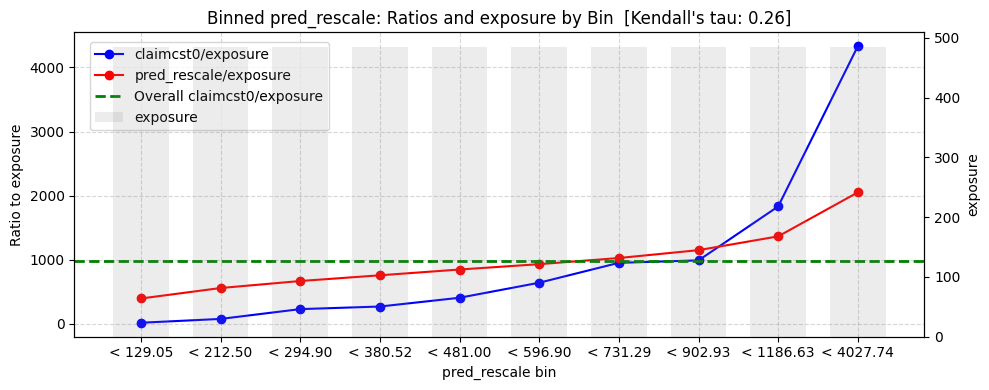

In [ ]:
# Select training samples for predictiveness check
data = final_model_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claimcst0'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute RMSE, Gini, MAE, and Tweedie Deviance
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
rmse = me.rmse()
mae = me.mae()
tweedie_dev = mean_tweedie_deviance(
    y_true=y,
    y_pred=y_pred,
    power=1.5    # same as model.tweedie_variance_power
)

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
# Tweedie Deviance
print(f"Tweedie Deviance: {tweedie_dev:.2f}")


pc.plot(figsize=(10, 4))



    1. Top Lift = 3.41
This means:

The top 10% of customers ranked by your model have 3.41× higher average loss than the portfolio overall.

That is very strong uplift.

In pricing/underwriting terms:

Your model sharply concentrates high-risk policies at the top of the predicted distribution.

If used in segmentation, the high-risk group would contain a disproportionate share of actual losses.

This is excellent for identifying high-loss segments and building risk tiers.

    2. Gini = 0.6682
A Gini of 0.67 is exceptionally high for an insurance severity or pure-premium model.

Interpretation:

The model improves risk ranking by 66.8% relative to random — indicating excellent discriminatory power.

This means:

The model is extremely good at sorting customers from low to high expected loss.

It provides highly actionable ranking for underwriting, risk segmentation, and pricing.

Even if absolute predictions are noisy (due to claim rarity), the ordering is outstanding.

    3. RMSE = 1722.59 & MAE = 685.50
Interpretation:

On average, the prediction misses the true claim cost per exposure by $685.

Large errors occur due to the heavy tail (RMSE is much larger than MAE).

This is exactly what you expect:

Losses are infrequent but severe when they occur.

RMSE is dominated by rare high-cost claims.

MAE represents a more realistic “average miss”.




In [76]:
# Model metrics on Validation Data
y_val = final_model_val_data['claimcst0'].astype(float)
exposure_val = final_model_val_data['exposure'].astype(float).clip(lower=1e-12)
X_val = final_model_val_data[final_preds].copy()

dval = xgb.DMatrix(
    X_val,
    label=y_val,
    base_margin=np.log(exposure_val)   # log exposure offset
)

val_pred = model.predict(dval)
final_model_val_data["pred"] = val_pred  # total predicted loss
final_model_val_data["pred_per_exposure"] = final_model_val_data["pred"] / final_model_val_data["exposure"]
rescale_factor_2 = final_model_val_data['claimcst0'].sum() / final_model_val_data['pred'].sum()
final_model_val_data['pred_rescale'] = final_model_val_data['pred'] * rescale_factor_2

Top Lift: 1.9809
Gini: 0.4901
RMSE: 1873.64
MAE: 762.71
Tweedie Deviance: 87.47


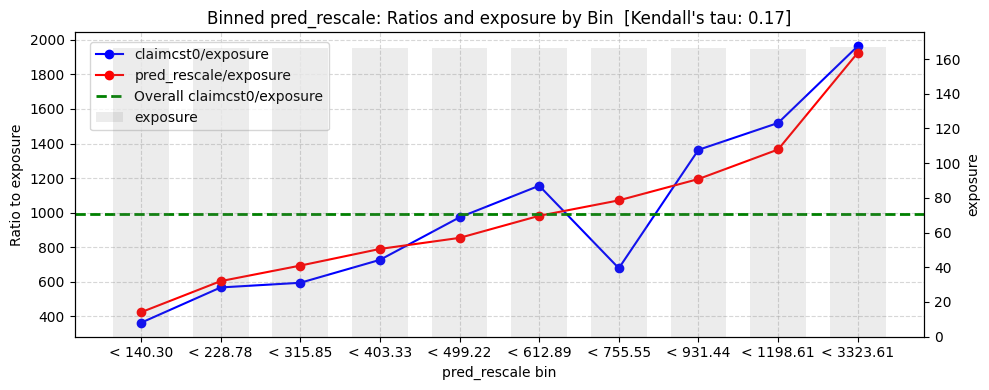

In [77]:
# Select validation samples for predictiveness check
data = final_model_val_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claimcst0'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute RMSE, Gini, MAE, and Tweedie Deviance
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
rmse = me.rmse()
mae = me.mae()
tweedie_dev = mean_tweedie_deviance(
    y_true=y,
    y_pred=y_pred,
    power=1.5    # same as model.tweedie_variance_power
)

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
# Tweedie Deviance
print(f"Tweedie Deviance: {tweedie_dev:.2f}")

pc.plot(figsize=(10, 4))

In [46]:
# calculate feature importance
importance = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,low_education_ind,137804688.0
10,engine_type,56773680.0
5,area,43138232.0
3,marital_status,42285172.0
4,time_driven,39911388.0
2,credit_score,34549000.0
7,gender,32941188.0
1,driving_history_score,32859116.0
12,veh_value,32575092.0
9,max_power,31743778.0


## Risk Segmentation

### Quantiles

In [19]:
train_data['predicted_expected_loss'] = y_pred

train_data.head()

/var/folders/nj/nbmj9gh56g9b50kd52cy7mwr0000gn/T/ipykernel_8963/2966020220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predicted_expected_loss'] = y_pred


,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss,predicted_expected_loss
0,1,2,1|bld,5.80,0.362191,SUV,2,F,B,1,...,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969,4190.744101
1,2,3,1|bld,5.67,0.632068,STNWG,4,F,A,2,...,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540,5273.055427
2,3,1,1|bld,5.90,0.367460,SEDAN,2,F,C,2,...,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127,4220.612971
3,4,2,1|bld,4.79,0.802184,STNWG,3,M,B,4,...,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513,3422.488947
4,5,2,1|bld,6.68,0.485009,SEDAN,3,M,C,1,...,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060,3485.267952


In [20]:
train_data["expected_loss"].quantile([0.33, 0.66])

0.33    0.0
0.66    0.0
Name: expected_loss, dtype: float64

### Fixed Thresholds

### KMeans Clustering

## Save Altered Data

In [ ]:
model_data.to_csv('../project/model_data.csv', index=False)
inference_data.to_csv('../project/inference_data.csv', index=False)

## Export Model Artifacts

In [24]:
# 1) Save the trained RandomForestRegressor
joblib.dump(rf, "../project/models/rf_model.pkl")

# 2) Save the exact feature column order used to fit the model
feature_columns = list(X_train.columns)  # if you trained with a DataFrame
with open("../project/models/feature_columns.json", "w") as f:
    json.dump(feature_columns, f)

# 3) (Optional) Create simple risk cutoffs from training predictions